# Comparison with Variance-reduced Zeroth order
In this notebook, we propose some experiments in order to compare SSZD with its variance-reduced variant.

## Imports

In [1]:
import os
import numpy as np
from sszd import SSZD, SSVRZD
import matplotlib
import matplotlib.pyplot as plt
from experiments_utils.synthetic_functions import BenchmarkFunction

out_dir = "./results/variance_reduced"

os.makedirs(out_dir, exist_ok=True)

## Auxiliary functions and variables

In [74]:
class StronglyConvexFunction(BenchmarkFunction):
    
    def __init__(self, d, seed =12):
        super().__init__("StronglyConvex", d)
        self.rnd_state = np.random.RandomState(seed = seed)
        self.A = self.rnd_state.rand(d, d)
        
    def __call__(self, x, z = None):
        if z is None:
            return 1/self.d * (np.linalg.norm(self.A.dot(x))**2)
        row = self.A[z, :]
        return (np.linalg.norm(row.dot(x))**2)

In [75]:
d = 5 # dimensions
rnd_state = np.random.RandomState(seed=1212)
strong_conv_target = StronglyConvexFunction(d, seed=12)

In [76]:
import time

def execute_experiment(alg, target, budget, x, z = None, deterministic=False):
    y_fun = [target(x)]
    ctime = [0]
    for k in range(1, budget):
        it_time = time.time()
        x = alg.step(target, x, z)
        it_time = time.time() - it_time
        if not deterministic:
            z = rnd_state.randint(low=0, high=d)
        y_fun.append(target(x))
        ctime.append(it_time)
    ctime = np.cumsum(ctime)
    return y_fun, ctime

## Strongly Convex Setting

In [78]:
# Parameters
A = strong_conv_target.A
w, _ = np.linalg.eigh(A.T.dot(A))

L = w[-1] / A.shape[0]
print(w[-1])
reps = 10

l = d

alpha = lambda k : 1e-1 * 1/(L * k) # Step-size
h = lambda k :   1/np.sqrt(k) # Discretization parameter


y_ssvrzd_sph, ctime_ssvrzd_sph = [], []
y_sszd_sph, ctime_sszd_sph = [], []
y_szd_sph, ctime_szd_sph = [], []

sszd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
szd_sph = SSZD('spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)
ssvrzd_sph = SSVRZD(10, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)


for _ in range(reps):
    x = np.asarray([1.0 for _ in range(d)])
    z = 0
    budget = 10000
    vr_y, vr_time = execute_experiment(ssvrzd_sph, strong_conv_target, budget, x, z)
    sszd_y, sszd_time = execute_experiment(sszd_sph, strong_conv_target, budget, x, z)
    szd_y, szd_time = execute_experiment(szd_sph, strong_conv_target, budget, x, None, True)

    y_ssvrzd_sph.append(vr_y)
    ctime_ssvrzd_sph.append(vr_time)
    y_sszd_sph.append(sszd_y)
    ctime_sszd_sph.append(sszd_time)
    y_szd_sph.append(szd_y)
    ctime_szd_sph.append(szd_time)
    sszd_sph.reset()
    szd_sph.reset()
    ssvrzd_sph.reset()


6.446662319637419


In [79]:
# Collect y results
sph_mean, sph_std = np.mean(y_sszd_sph, axis=0), np.std(y_sszd_sph, axis=0)
sph_det_mean, sph_det_std = np.mean(y_szd_sph, axis=0), np.std(y_szd_sph, axis=0)
sph_vr_mean, sph_vr_std = np.mean(y_ssvrzd_sph, axis=0), np.std(y_ssvrzd_sph, axis=0)

# Collect y results
sph_mean_tm, sph_std_tm = np.mean(ctime_sszd_sph, axis=0), np.std(ctime_sszd_sph, axis=0)
sph_det_mean_tm, sph_det_std_tm = np.mean(ctime_szd_sph, axis=0), np.std(ctime_szd_sph, axis=0)
sph_vr_mean_tm, sph_vr_std_tm = np.mean(ctime_ssvrzd_sph, axis=0), np.std(ctime_ssvrzd_sph, axis=0)



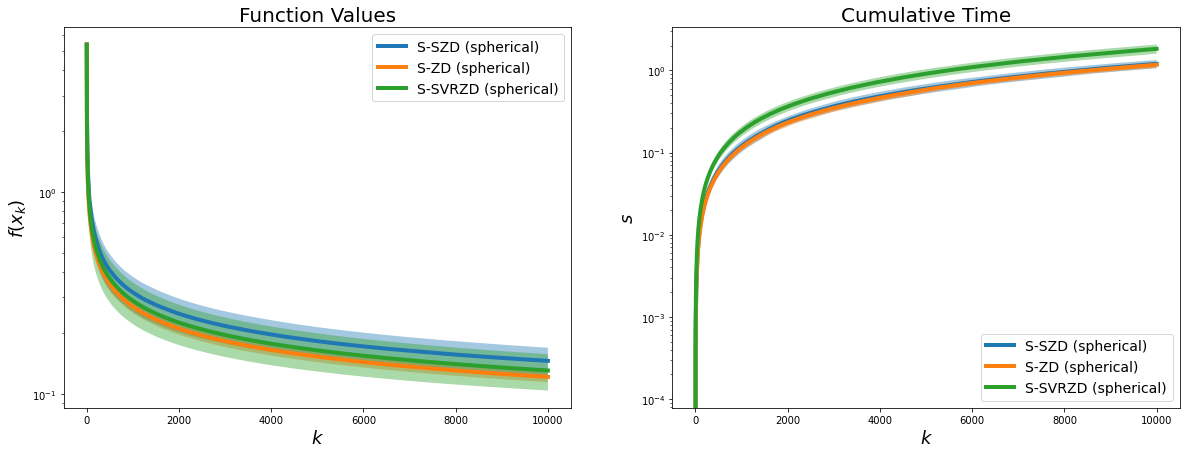

In [80]:

   
def plot_mean_std(ax, mean, std, label):
    ax.plot(range(len(mean)),   mean, '-', lw=4, label=label)
    ax.fill_between(range(len(mean)),  mean + std, mean - std, alpha=0.4)
   

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
ax1.set_title("Function Values", fontsize=20)
ax2.set_title("Cumulative Time", fontsize=20)

plot_mean_std(ax1, sph_mean, sph_std, label="S-SZD (spherical)")
plot_mean_std(ax1, sph_det_mean, sph_det_std, label="S-ZD (spherical)")
plot_mean_std(ax1, sph_vr_mean, sph_vr_std, label="S-SVRZD (spherical)")

plot_mean_std(ax2, sph_mean_tm, sph_std_tm, label="S-SZD (spherical)")
plot_mean_std(ax2, sph_det_mean_tm, sph_det_std_tm, label="S-ZD (spherical)")
plot_mean_std(ax2, sph_vr_mean_tm, sph_vr_std_tm, label="S-SVRZD (spherical)")




ax1.set_xlabel("$k$", fontsize=18)
ax1.set_ylabel("$f(x_k)$", fontsize=18)
ax2.set_xlabel("$k$", fontsize=18)
ax2.set_ylabel("$s$", fontsize=18)

ax1.legend(loc="upper right", fontsize=14)
ax1.set_yscale("log")
ax2.legend(loc="lower right", fontsize=14)
ax2.set_yscale("log")


# Convex

In [84]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
    


#Loading the data
data = load_breast_cancer()

#Preparing the data
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)
def sigmoid(x, weight):
    z = np.dot(x, weight)
    return 1 / (1 + np.exp(-z))

def binary_cross_entropy(weight, data=None):
    weight = np.exp(weight)
    if data is None:
        X_tr, y_tr = X_train, y_train
    else:
        X_tr, y_tr = data[0], data[1]
    h = sigmoid(X_tr, weight)

    return (-y_tr * np.log(h) - (1 - y_tr) * np.log(1 - h)).mean()


d = l = x.shape[1]

alpha = lambda k : 1/np.sqrt(k)
h = lambda k : 1/k

ssvrzd_sph = SSVRZD(10, 'spherical', d, l,  alpha, h,  dtype = np.float64, seed = 12)

binary_cross_entropy(np.zeros(X_train.shape[1]) + 1e2)


/tmp/ipykernel_73263/2731603050.py:26: RuntimeWarning: divide by zero encountered in log
  return (-y_tr * np.log(h) - (1 - y_tr) * np.log(1 - h)).mean()
/tmp/ipykernel_73263/2731603050.py:26: RuntimeWarning: invalid value encountered in multiply
  return (-y_tr * np.log(h) - (1 - y_tr) * np.log(1 - h)).mean()


nan

In [82]:
class LogisticRegression:
    def __init__(self,x,y):      
        self.intercept = np.ones((x.shape[0], 1))  
        self.x = np.concatenate((self.intercept, x), axis=1)
        self.weight = np.zeros(self.x.shape[1])
        self.y = y
        
    #Sigmoid method
    def sigmoid(self, x, weight):
        z = np.dot(x, weight)
        return 1 / (1 + np.exp(-z))
    
    #method to calculate the Loss
    def loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    #Method for calculating the gradients
    def gradient_descent(self, X, h, y):
        return np.dot(X.T, (h - y)) / y.shape[0]

    
    def fit(self, lr , iterations):
        for i in range(iterations):
            sigma = self.sigmoid(self.x, self.weight)
            
            loss = self.loss(sigma,self.y)

            dW = self.gradient_descent(self.x , sigma, self.y)
            
            #Updating the weights
            self.weight -= lr * dW

        return print('fitted successfully to data')
    
    #Method to predict the class label.
    def predict(self, x_new , treshold):
        x_new = np.concatenate((self.intercept, x_new), axis=1)
        result = self.sigmoid(x_new, self.weight)
        result = result >= treshold
        y_pred = np.zeros(result.shape[0])
        for i in range(len(y_pred)):
            if result[i] == True: 
                y_pred[i] = 1
            else:
                continue
                
        return y_pred